# Bag of Little Bootstraps analysis

This notebook inspects our Bag of Little Bootstraps implementation to see how it is doing.

## Setup

Load libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import bootstrap

In [2]:
from lenskit.stats._blb import _BLBootstrapper, blb_summary

In [3]:
rng = np.random.default_rng(20250602)

## Initial Test — N=10,000

In [38]:
N = 10_000
TRUE_MEAN = 0.1
data = rng.normal(TRUE_MEAN, 1.0, N)
mean = np.mean(data)
std = np.std(data)
ste = std / np.sqrt(N)
print("{:.4f} ({:.4f}, {:.4f})".format(mean, mean - 1.96 * ste, mean + 1.96 * ste))

0.0952 (0.0756, 0.1148)


In [39]:
boot_res = bootstrap([data], np.mean)
boot_res.confidence_interval

ConfidenceInterval(low=np.float64(0.07528506138908903), high=np.float64(0.11462418644027217))

In [47]:
blb = _BLBootstrapper(np.average, 0.95, 0.01, 3, 20, 0.7, rng)
blb_df = blb.run_bootstraps(data).samples
_gstat = blb_df.groupby(["subset"])["statistic"]
blb_df["cum_mean"] = _gstat.cumsum() / (_gstat.cumcount() + 1)
blb_df = blb_df.reset_index()

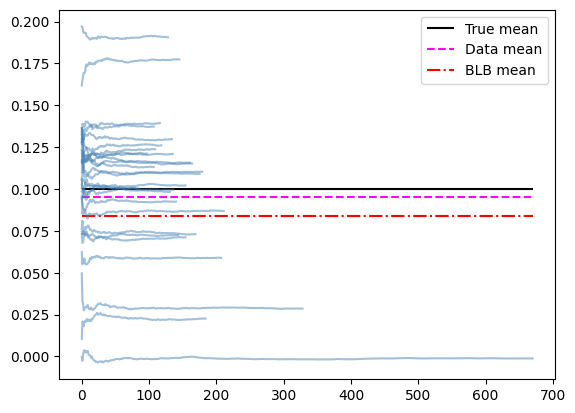

In [48]:
plt.hlines([TRUE_MEAN], xmin=0, xmax=blb_df["iter"].max(), label="True mean", color="black")
plt.hlines([mean], xmin=0, xmax=blb_df["iter"].max(), label="Data mean", color="magenta", ls="--")
plt.hlines(
    [blb_df["statistic"].mean()],
    xmin=0,
    xmax=blb_df["iter"].max(),
    color="red",
    label="BLB mean",
    ls="-.",
)
for snum, sdf in blb_df.groupby("subset"):
    plt.plot(sdf["iter"], sdf["cum_mean"], color="steelblue", alpha=0.5)
plt.legend()
plt.show()

In [49]:
blb_sdf = (
    blb_df.groupby("subset")["statistic"]
    .apply(
        lambda x: pd.Series(
            {
                "mean": x.mean(),
                "stderr": x.std(),
                "ci_lower": np.quantile(x, 0.025),
                "ci_upper": np.quantile(x, 0.975),
            }
        )
    )
    .unstack()
)
blb_sdf

,mean,stderr,ci_lower,ci_upper
subset,,,,
0,0.058831,0.009507,0.040531,0.078314
1,0.022663,0.010140,0.004403,0.042291
2,0.072463,0.009355,0.054276,0.088416
3,0.086848,0.008889,0.068695,0.106284
4,0.102174,0.009807,0.083923,0.121398
5,0.098283,0.010168,0.078821,0.115761
6,0.073001,0.009974,0.056203,0.092642
7,0.100349,0.009426,0.082732,0.117557
8,0.190546,0.009800,0.174566,0.211778


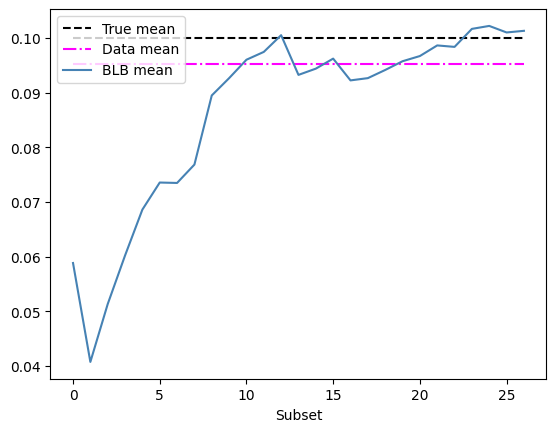

In [50]:
plt.hlines([TRUE_MEAN], xmin=0, xmax=blb_sdf.index.max(), label="True mean", color="black", ls="--")
plt.hlines([mean], xmin=0, xmax=blb_sdf.index.max(), label="Data mean", color="magenta", ls="-.")
plt.plot(
    blb_sdf.index,
    blb_sdf["mean"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
    label="BLB mean",
)
plt.xlabel("Subset")
plt.legend()
plt.show()

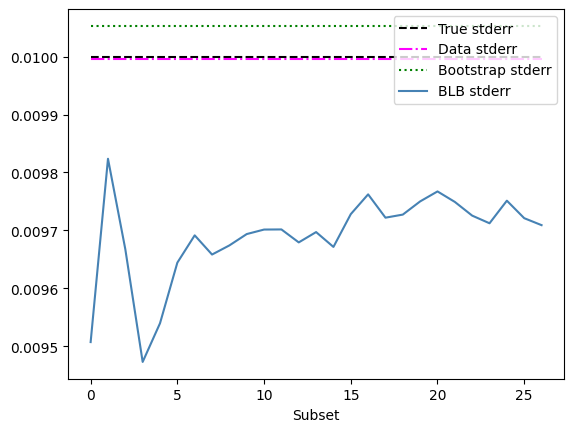

In [51]:
plt.hlines(
    [1 / np.sqrt(N)], xmin=0, xmax=blb_sdf.index.max(), label="True stderr", color="black", ls="--"
)
plt.hlines([ste], xmin=0, xmax=blb_sdf.index.max(), label="Data stderr", color="magenta", ls="-.")
plt.hlines(
    [boot_res.standard_error],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="Bootstrap stderr",
    color="green",
    ls=":",
)
plt.plot(
    blb_sdf.index,
    blb_sdf["stderr"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
    label="BLB stderr",
)
plt.xlabel("Subset")
plt.legend()
plt.show()

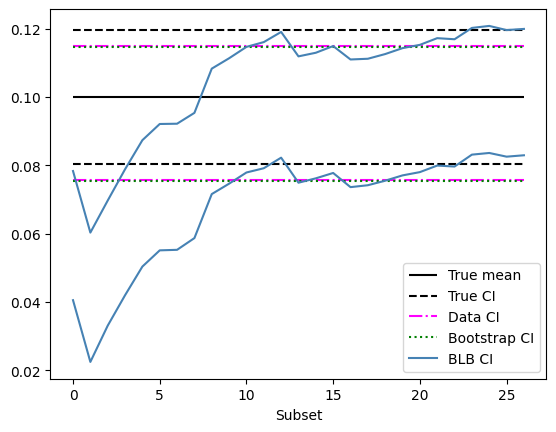

In [52]:
plt.hlines([TRUE_MEAN], xmin=0, xmax=blb_sdf.index.max(), label="True mean", color="black")
plt.hlines(
    [TRUE_MEAN - 1.96 / np.sqrt(N), TRUE_MEAN + 1.96 / np.sqrt(N)],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="True CI",
    color="black",
    ls="--",
)
plt.hlines(
    [mean - 1.96 * ste, mean + 1.96 * ste],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="Data CI",
    color="magenta",
    ls="-.",
)
plt.hlines(
    [boot_res.confidence_interval.low, boot_res.confidence_interval.high],
    xmin=0,
    xmax=blb_sdf.index.max(),
    label="Bootstrap CI",
    color="green",
    ls=":",
)
plt.plot(
    blb_sdf.index,
    blb_sdf["ci_lower"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
    label="BLB CI",
)
plt.plot(
    blb_sdf.index,
    blb_sdf["ci_upper"].cumsum() / (blb_sdf.index.values + 1),
    color="steelblue",
)
plt.xlabel("Subset")
plt.legend()
plt.show()

## Randomized Testing

Now let's test a bunch of possible values.

In [ ]:
M = 200
N = 100_000
means = rng.normal(0, 10, size=M)
stds = rng.standard_exponential(size=M) + 0.1

data = rng.normal(
    np.broadcast_to(means.reshape((M, 1)), (M, N)), np.broadcast_to(stds.reshape((M, 1)), (M, N))
)
data.shape

(200, 100000)

In [ ]:
data_means = np.mean(data, axis=1)
data_stds = np.std(data, axis=1)
param_stats = pd.DataFrame(
    {
        "mean": data_means,
        "ci_lower": data_means - 1.96 * (data_stds / np.sqrt(N)),
        "ci_upper": data_means - 1.96 * (data_stds / np.sqrt(N)),
    }
)

In [ ]:
# boots = [bootstrap([data[i, :]], np.mean, n_resamples=5000) for i in range(M)]
# boot_stats = pd.DataFrame.from_records(
#     {
#         "mean": np.mean(data[i, :]),
#         "ci_lower": boot.confidence_interval.low,
#         "ci_upper": boot.confidence_interval.high,
#     }
#     for i, boot in enumerate(boots)
# )
# boot_stats

In [ ]:
blbs = [blb_summary(data[i, :], "mean", b_factor=0.8) for i in range(M)]
blb_stats = pd.DataFrame.from_records(blbs)
blb_stats

KeyboardInterrupt: 

In [ ]:
comb_stats = pd.DataFrame(
    {
        "Parametric": param_stats.unstack(),
        # "Bootstrap": boot_stats.unstack(),
        "BLB": blb_stats.drop(columns=["value"]).unstack(),
    }
)
comb_stats.index.rename(["quantity", "samp"], inplace=True)
comb_stats["Error"] = comb_stats["BLB"] - comb_stats["Parametric"]
comb_stats["RelError"] = (
    np.abs(comb_stats["BLB"] - comb_stats["Parametric"]) / comb_stats["Parametric"].abs()
)
comb_stats

Parametric  Bootstrap        BLB     Error  RelError
quantity samp                                                      
ci_lower 0       2.597184  -4.423093   2.593609 -0.003575  0.001377
         1     -12.386757  -4.425957 -12.386300  0.000458  0.000037
         2      13.514136  -8.080191  13.510683 -0.003453  0.000256
         3       9.921847 -25.329503   9.921969  0.000122  0.000012
         4      -0.510517  -2.748500  -0.509992  0.000526  0.001029
...                   ...        ...        ...       ...       ...
mean     195     1.883268        NaN   1.884418  0.001150  0.000611
         196   -12.321563        NaN -12.321220  0.000343  0.000028
         197    19.500813        NaN  19.500918  0.000105  0.000005
         198    -7.208713        NaN  -7.208516  0.000196  0.000027
         199     9.404558        NaN   9.404817  0.000259  0.000028

[600 rows x 5 columns]

In [ ]:
comb_stats = comb_stats.join(
    pd.Series(means, name="RealMean", index=pd.Index(np.arange(M), name="samp"))
)
comb_stats = comb_stats.join(
    pd.Series(stds, name="RealSTD", index=pd.Index(np.arange(M), name="samp"))
)
comb_stats["AbsMean"] = comb_stats["RealMean"].abs()
comb_stats.reset_index(inplace=True)
comb_stats

,quantity,samp,Parametric,Bootstrap,BLB,Error,RelError,RealMean,RealSTD,AbsMean
0,ci_lower,0,2.597184,-4.423093,2.593609,-0.003575,0.001377,2.601141,1.592588,2.601141
1,ci_lower,1,-12.386757,-4.425957,-12.386300,0.000458,0.000037,-12.385795,0.547635,12.385795
2,ci_lower,2,13.514136,-8.080191,13.510683,-0.003453,0.000256,13.514852,1.421265,13.514852
3,ci_lower,3,9.921847,-25.329503,9.921969,0.000122,0.000012,9.922137,0.140994,9.922137
4,ci_lower,4,-0.510517,-2.748500,-0.509992,0.000526,0.001029,-0.509412,0.362041,0.509412
...,...,...,...,...,...,...,...,...,...,...
595,mean,195,1.883268,NaN,1.884418,0.001150,0.000611,1.884801,2.149275,1.884801
596,mean,196,-12.321563,NaN,-12.321220,0.000343,0.000028,-12.319299,2.509345,12.319299
597,mean,197,19.500813,NaN,19.500918,0.000105,0.000005,19.501153,0.612372,19.501153
598,mean,198,-7.208713,NaN,-7.208516,0.000196,0.000027,-7.209443,0.213760,7.209443


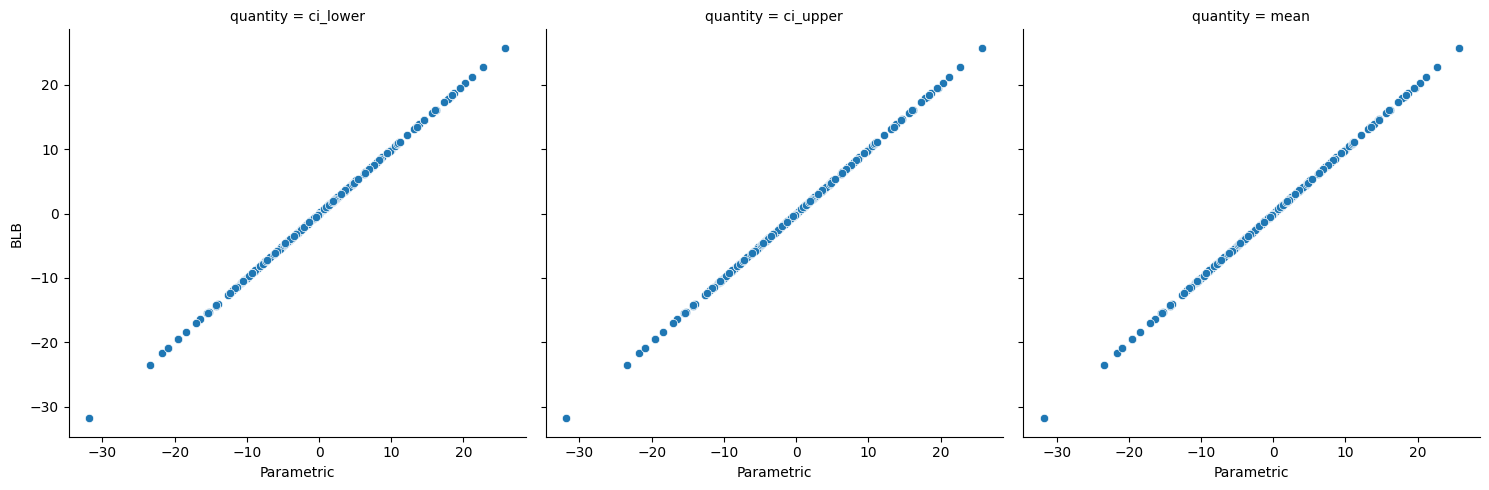

In [ ]:
sns.relplot(comb_stats, x="Parametric", y="BLB", col="quantity", kind="scatter")
plt.show()

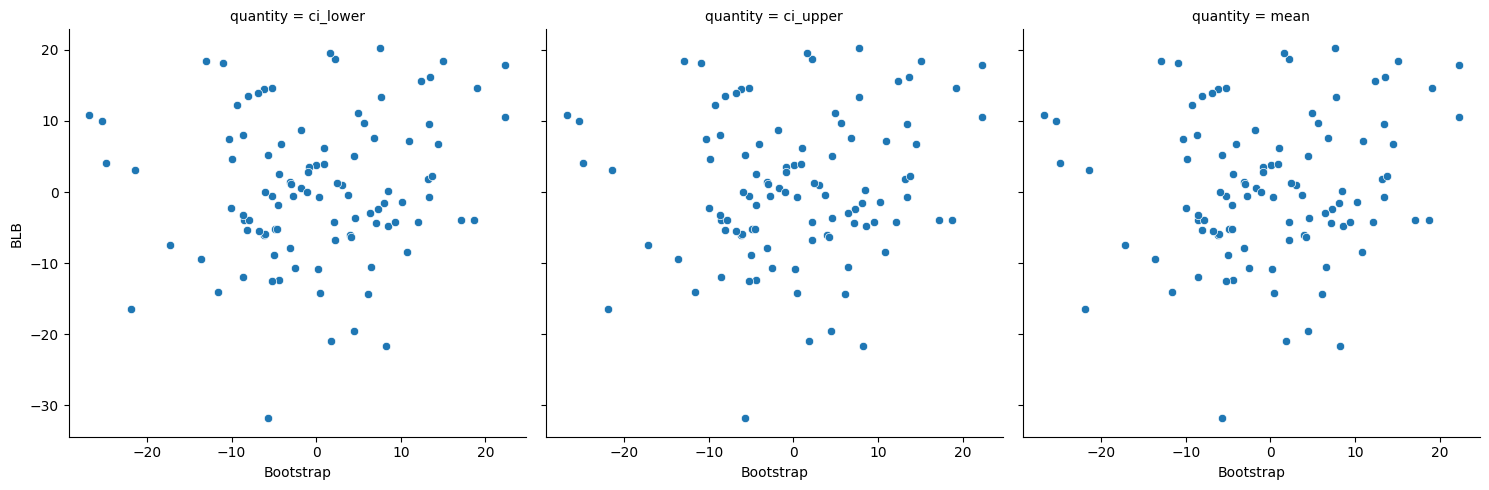

In [ ]:
sns.relplot(comb_stats, x="Bootstrap", y="BLB", col="quantity", kind="scatter")
plt.show()

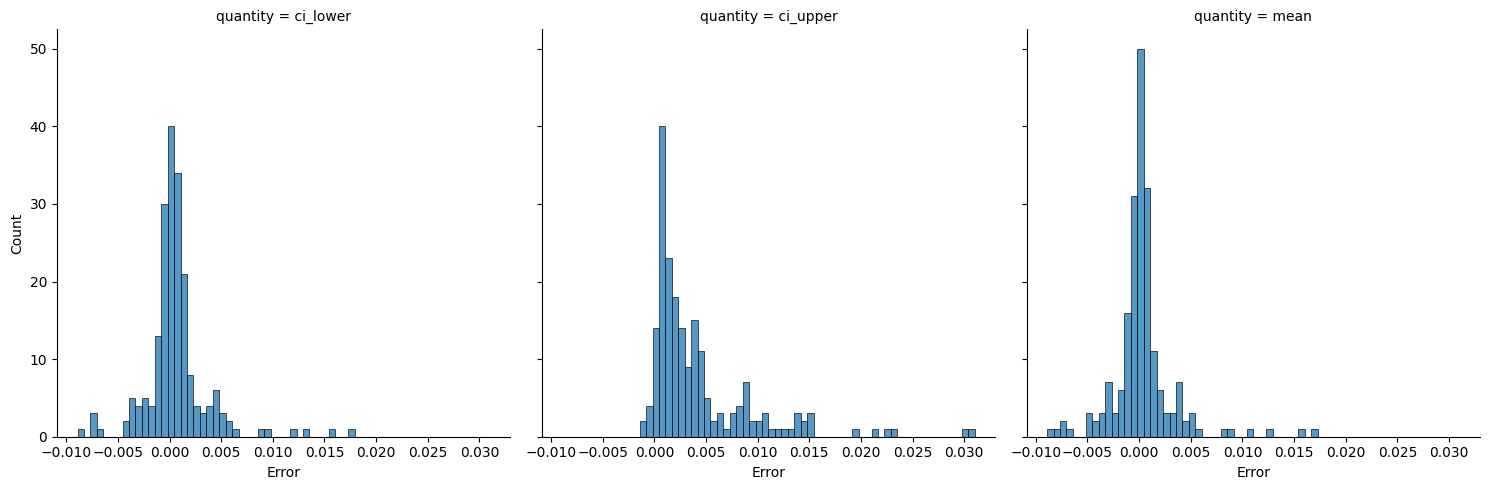

In [ ]:
sns.displot(comb_stats, x="Error", col="quantity")

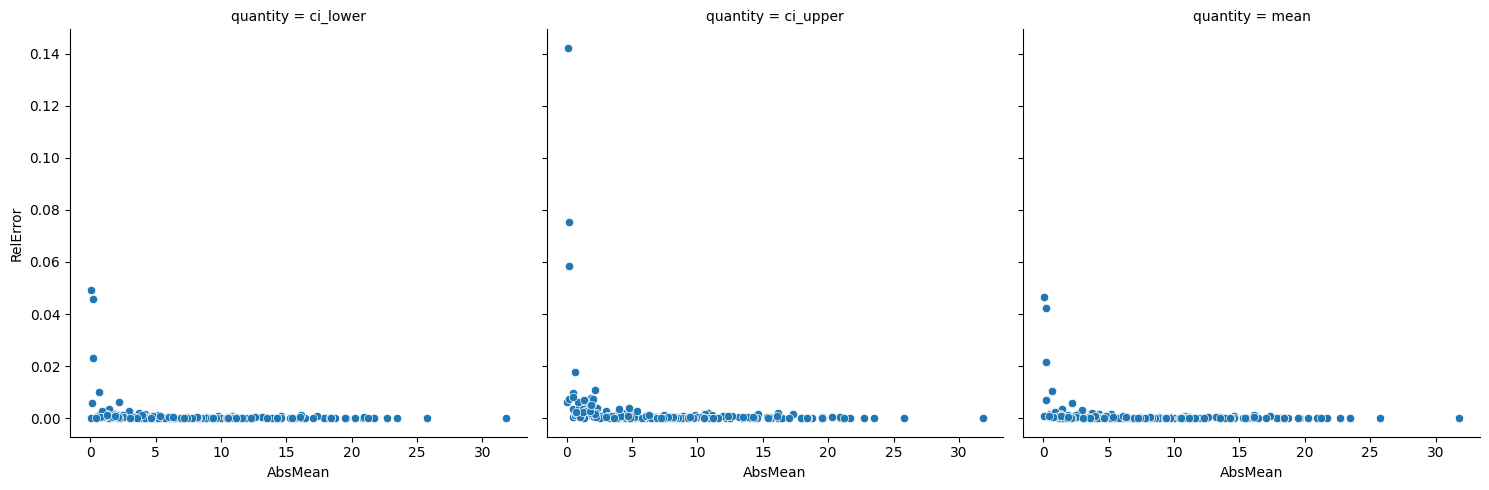

In [ ]:
sns.relplot(comb_stats, x="AbsMean", y="RelError", col="quantity", kind="scatter")

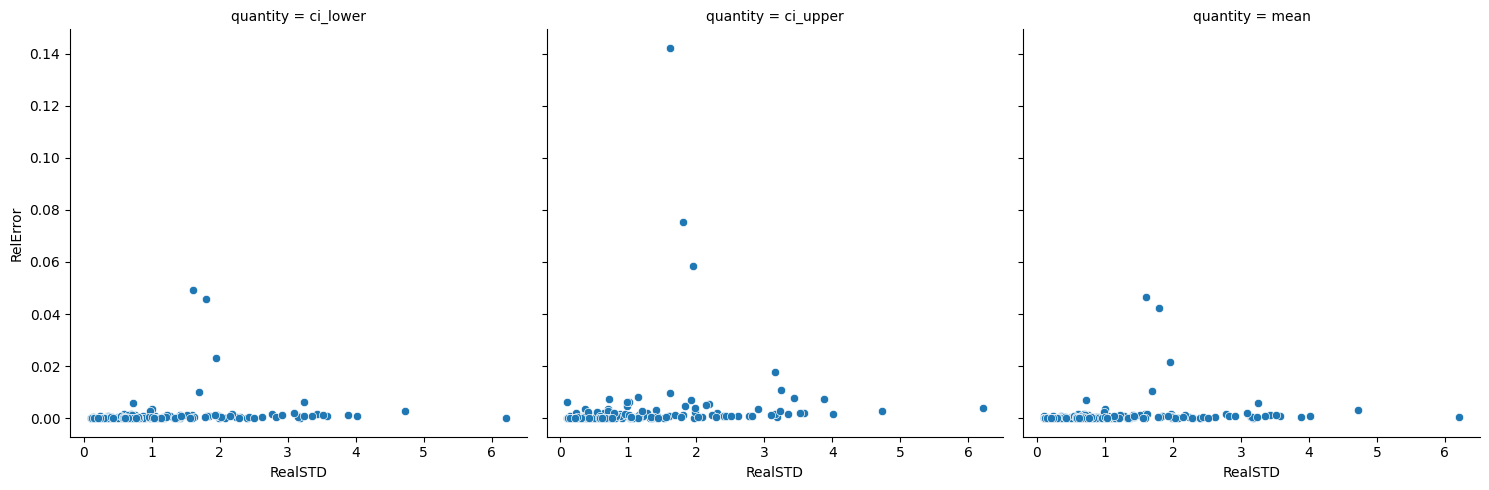

In [ ]:
sns.relplot(comb_stats, x="RealSTD", y="RelError", col="quantity", kind="scatter")